In [6]:
### IMPORT LIBARIES AND FUNCTIONS
# Standard libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Going to make sure we can load all the custom scripts from the directory
scripts_dir = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis"
# Add scripts directory to sys.path
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
from model_dependence import model_dependence
from analysis_functions import basin_loss_curve, interpolate_damages, get_copula_model, generate_conditional_sample, sectoral_monte_carlo_dependence_simulation, run_DIGNAD

In [2]:
### STEP 1: Calibrate Copulas
clayton_copula_models, ordered_basins = model_dependence()

In [3]:
### STEP 2: Load and clean risk data
risk_data_file = r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\dignad\exposure\risk_basin_zonal_sum.csv"
risk_data = pd.read_csv(risk_data_file)
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
# Add row for each combination that sums residential and non-residential damages
grouped = risk_data.groupby(['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'], as_index=False)['damages'].sum()
grouped['urban_class'] = 'Combined'  # Add a column for urban_class with value 'total'
risk_data = pd.concat([risk_data, grouped], ignore_index=True).sort_values(by=['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'])
risk_data.reset_index(drop=True, inplace=True)

In [7]:
### STEP 3: Run the simulation
# Run the simulation
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000] # these are the RPs we are considering
n_simulations = 1000
n_years = 100
basin = 'HB_L6' # only looking at HydroBASIN level 6 basins
epoch ='Today'
scenario = 'Baseline'
res_df, com_df, ind_df, inf_df = sectoral_monte_carlo_dependence_simulation(risk_data, rps, basin, epoch, scenario, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)

In [31]:
### STEP 4: Functions for DIGNAD preperation
def dignad_loss_probability(res_df, com_df, ind_df, inf_df, res_share_pri, res_share_tra, com_share_pri, com_share_tra, ind_share_pri, ind_share_tra, inf_share_pri, inf_share_tra, tradable_cap_stock, nontradable_cap_stock, GDP):
    '''
    Function for converting loss probability curves to DIGNAD compliant loss-pobability curves.
    Also creates a total capital stock loss-probability curve.
    Inputs needed include sectoral loss dataframes, sectoral share for private and tradable capital stock, capital stock (tradable and nontradable) and GDP.
    Outputs 7 flattened and sorted arrays
    '''
    # Flatten arrays
    res_losses = res_df.values.flatten()
    com_losses = com_df.values.flatten()
    ind_losses = ind_df.values.flatten()
    inf_losses = inf_df.values.flatten()
    total_losses = res_losses + com_losses + ind_losses + inf_losses

    # Calculate share of private, public, tradable and non-tradable losses (for DIGNAD)
    tradable_perc_impact = ((res_losses * res_share_tra) + (com_losses * com_share_tra) + (ind_losses * ind_share_tra) +
                            (inf_losses * inf_share_tra))/tradable_cap_stock
    nontradable_perc_impact = ((res_losses * (1-res_share_tra)) + (com_losses * (1-com_share_tra)) + (ind_losses * (1-ind_share_tra)) +
                            (inf_losses * (1-inf_share_tra)))/nontradable_cap_stock
    private_perc_impact = ((res_losses * res_share_pri) + (com_losses * com_share_pri) + (ind_losses * ind_share_pri) +
                            (inf_losses * inf_share_pri))/GDP
    public_perc_impact = ((res_losses * (1-res_share_pri)) + (com_losses * (1-com_share_pri)) + (ind_losses * (1-ind_share_pri)) +
                            (inf_losses * (1-inf_share_pri)))/GDP
    share_tradable = ((res_losses * res_share_tra) + (com_losses * com_share_tra) + (ind_losses * ind_share_tra) + (inf_losses * inf_share_tra)) / ((res_losses * res_share_pri) + (com_losses * com_share_pri) + (ind_losses * ind_share_pri) + (inf_losses * inf_share_pri))

    # Sort the layers based on total losses
    sorted_indices = np.argsort(total_losses)
    sorted_losses = total_losses[sorted_indices]
    sorted_tradable = tradable_perc_impact[sorted_indices]
    sorted_nontradable = nontradable_perc_impact[sorted_indices]
    sorted_public = public_perc_impact[sorted_indices]
    sorted_private = private_perc_impact[sorted_indices]
    sorted_share_tradable = share_tradable[sorted_indices]

    return sorted_losses, sorted_tradable, sorted_nontradable, sorted_public, sorted_private, sorted_share_tradable

# Functions for extracting data
def get_loss_for_rp(return_period, sorted_losses, exceedance_probs):
    ep = 1 / return_period
    if ep >= exceedance_probs[0]:
        return sorted_losses[0]
    elif ep <= exceedance_probs[-1]:
        return sorted_losses[-1]
    else:
        return np.interp(ep, exceedance_probs[::-1], sorted_losses[::-1])
        
# Function for extracting DIGNAD data for a specific return period
def get_dignad_inputs_for_rp(return_period, exceedance_probabilities, sorted_tradable, sorted_nontradable, sorted_public, sorted_private, sorted_share_tradable):
    tradable_impact = get_loss_for_rp(return_period, sorted_tradable, exceedance_probabilities)
    nontradable_impact = get_loss_for_rp(return_period, sorted_nontradable, exceedance_probabilities)
    public_impact = get_loss_for_rp(return_period, sorted_public, exceedance_probabilities)
    private_impact = get_loss_for_rp(return_period, sorted_private, exceedance_probabilities)
    share_tradable = get_loss_for_rp(return_period, sorted_share_tradable, exceedance_probabilities)
    return tradable_impact, nontradable_impact, public_impact, private_impact, share_tradable

In [29]:
### STEP 5: Extract DIGNAD compliant loss-probability curves
losses, tradable, nontradable, public, private, share_tradable = dignad_loss_probability(res_df, com_df, ind_df, inf_df, 0.911, 0, 0.7205,
                                                                                        0.3544, 0.885, 0.8503, 0.4208, 0, 14241662000000,
                                                                                        25778622000000, 17367000000000) 

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_39428\1932842248.py:25: RuntimeWarning: invalid value encountered in divide
  share_tradable = ((res_losses * res_share_tra) + (com_losses * com_share_tra) + (ind_losses * ind_share_tra) + (inf_losses * inf_share_tra)) / ((res_losses * res_share_pri) + (com_losses * com_share_pri) + (ind_losses * ind_share_pri) + (inf_losses * inf_share_pri))


In [103]:
### STEP 6: Run DIGNAD
# Calculate exceedance probabilities
num_losses = len(losses)
exceedance_probabilities = np.arange(num_losses, 0, -1) / num_losses
# User inpnuts ######
calibration_csv = r"D:\projects\sovereign-risk\Thailand\data\DIGNAD\inputs\THA_2010_calibration.csv"
rp = 100
nat_disaster_year = 2022
recovery_period = 5 # years
reconstruction_efficiency = 0
public_debt_premium = 0
#####################
# Extract data from loss-probability curve
tradable_impact, nontradable_impact, public_impact, private_impact, share_tradable_impact = get_dignad_inputs_for_rp(rp, exceedance_probabilities,
                                                                                                                    tradable, nontradable, public,
                                                                                                                    private, share_tradable)
# Run DIGNAD
gdp_impact, years = run_DIGNAD(calibration_csv, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact, reconstruction_efficiency,
                                public_debt_premium, public_impact, private_impact, share_tradable_impact)

-5.737310262200202
-1.7854716967873743
-4.431553436170193
[-5.737310262200202, -5.167319838681406, -3.8348020466891453, -2.986781597110022, -2.4334865614441092]


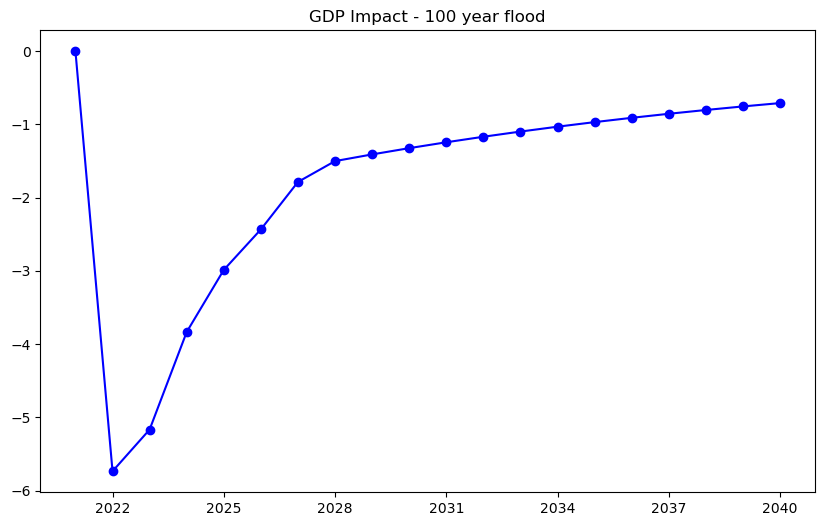

In [105]:
# Plot the data
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,6))
plt.plot(years, gdp_impact, marker='o', linestyle='-', color='b', label='GDP losses')
plt.title('GDP Impact - 100 year flood')
# Ensure x-axis shows whole numbers and every year
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
print(np.min(gdp_impact))
print(np.mean(gdp_impact))
print(np.mean(gdp_impact[1:5]))
print(gdp_impact[1:6])

In [64]:
### EXTRA: SENSITIVITY ANALYSIS
# What parameter are we going to assess sensitvity of?
reconstruction_efficiencies = np.linspace(0, 0.5, 10)
public_debt_premiums = np.linspace(0, 0.5, 10)
# Calculate exceedance probabilities
num_losses = len(losses)
exceedance_probabilities = np.arange(num_losses, 0, -1) / num_losses
# User inpnuts ######
calibration_csv = r"D:\projects\sovereign-risk\Thailand\data\DIGNAD\inputs\THA_2010_calibration.csv"
rp = 100
nat_disaster_year = 2022
recovery_period = 5 # years
#reconstruction_efficiency = 0
#public_debt_premium = 0
#####################
# Run sensitivity analysis
results = []
for reconstruction_efficiency in reconstruction_efficiencies:
    for public_debt_premium in public_debt_premiums:
        gdp_impact, years = run_DIGNAD(calibration_csv, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact, reconstruction_efficiency,
                                    public_debt_premium, public_impact, private_impact, share_tradable_impact)
        avg_gdp_impact = np.mean(gdp_impact)
        max_gdp_impact = np.min(gdp_impact)
        results.append({
            'Reconstruction Efficiency': reconstruction_efficiency,
            'Public Debt Premium': public_debt_premium,
            'Avg GDP Impact': avg_gdp_impact,
            'Max GDP Impact': max_gdp_impact
        })
results_df = pd.DataFrame(results)

In [65]:
results_df

,Reconstruction Efficiency,Public Debt Premium,Avg GDP Impact,Max GDP Impact
0,0.0,0.000000,-1.785472,-5.737310
1,0.0,0.055556,-1.851142,-5.736685
2,0.0,0.111111,-1.919688,-5.736016
3,0.0,0.166667,-1.991205,-5.735310
4,0.0,0.222222,-2.065792,-5.734571
...,...,...,...,...
95,0.5,0.277778,-2.374497,-5.730749
96,0.5,0.333333,-2.459914,-5.729854
97,0.5,0.388889,-2.548836,-5.728935
98,0.5,0.444444,-2.641379,-5.727999


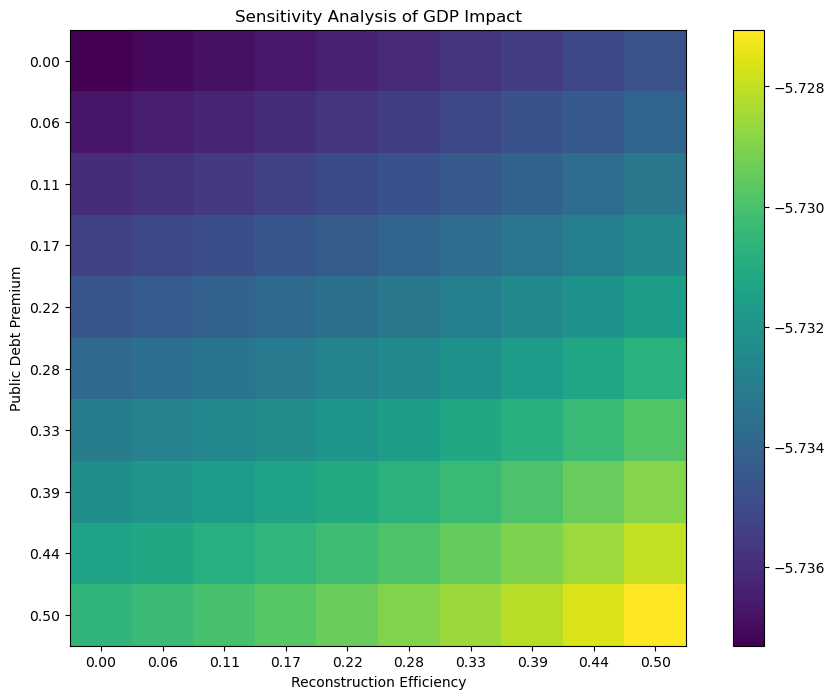

In [66]:
# Plot sensitivity
fig, ax = plt.subplots(figsize=(12, 8))

# Pivot the DataFrame to a suitable format for heatmap plotting
pivot_table = results_df.pivot_table(values='Max GDP Impact', index='Public Debt Premium', columns='Reconstruction Efficiency')

cax = ax.matshow(pivot_table, cmap='viridis')
fig.colorbar(cax)

# Set axis labels
ax.set_xlabel('Reconstruction Efficiency')
ax.set_ylabel('Public Debt Premium')

# Set ticks based on the pivot table shape
ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_yticks(np.arange(len(pivot_table.index)))

# Set tick labels based on the actual unique values used in the pivot table
ax.set_xticklabels([f"{eff:.2f}" for eff in pivot_table.columns])
ax.set_yticklabels([f"{debt:.2f}" for debt in pivot_table.index])

# Move x tick labels to the bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')

plt.title('Sensitivity Analysis of GDP Impact')
plt.show()